# Article Relevance Prediction for NeotomaDB
## Baseline Model with BOW Features

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Decisions on Features
3. Make preprocessing pipeline & Run baseline models with BOW features & Model Comparison
4. Feature Selection
5. Model evaluation
6. Summary

## 1. Data Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

In [9]:
# load csv
metadata_df = pd.read_csv("../data/processed/metadata_processed.csv", index_col=0)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4461
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     4435 non-null   object
 1   URL                     4435 non-null   object
 2   abstract                2080 non-null   object
 3   author                  3978 non-null   object
 4   container-title         4428 non-null   object
 5   is-referenced-by-count  4435 non-null   int64 
 6   language                4435 non-null   object
 7   published               4435 non-null   object
 8   publisher               4431 non-null   object
 9   subject                 4346 non-null   object
 10  subtitle                4435 non-null   object
 11  title                   4435 non-null   object
 12  target                  4435 non-null   int64 
 13  published_year          4435 non-null   int64 
 14  title_clean             4435 non-null   object
 15  subt

In [10]:
metadata_df.head(1)

,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,...,target,published_year,title_clean,subtitle_clean,abstract_clean,subject_clean,has_abstract,text_with_abstract,text_wo_abstract,detectlang
0,10.2478/s11756-007-0072-x,http://dx.doi.org/10.2478/s11756-007-0072-x,NaN,"[{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...",Biologia,13,en,"{'date-parts': [[2006, 12]]}",Springer Science and Business Media LLC,"['Cell Biology', 'Plant Science', 'Genetics', 'Molecular Biology', 'Animal Science and Zoology', 'Biochemistry', 'Ecology, Evolution, Behavior and Systematics']",...,1,2006,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",NaN,NaN,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics",1,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest","The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",en


## 2. Decisions on Features

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Drop it during training. |
| URL | Link to the article | Drop it during training.|
|abstract | Abstract of the article. Only a small proportion of NeotomaDB articles has it. | Concatenate with title, then convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Decision: to make the model more generalizable to new journals, we will remove this feature. This also helps with dimension reduction with low cost of model performance. The subject feature is kept as a proxy of journal. |
| **is-referenced-by-count**| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. Imputed with langdetect when missing. Only English articles are kept.|
| published | contain datatime information about when the article is published. | Decision: Drop the year of publication since it is not deemed as an informative feature.|
| publisher | Publisher name | Decision: drop to reduce dimension, and it is not a very informative feature. |
| **subject**| What subject the **journal** is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Concatenate with title and then convert to Bag of words feature.|
| title | Title of the article. | Concatenate with title and abstract, then convert to Bag of words feature|
| **has_abstract** | Binary indicator.| Binary OHE feature.|
| **text_with_abstract** | Concatenated text: title + subtitle + abstract| BOW feature|
| text_wo_abstract | Concatenated text: title + subtitle (for experimental purpose) | Decision: We will use information from abstract to make better prediction.|
| detectlang | Imputed language using 'text_with_abstract' and detectlang package. | Value is used to impute missing language. Can be dropped now.|






In [15]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4461
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4435 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 207.9+ KB


In [18]:
# Replace Missing value in subject_clean to empty string to avoid error in BOW transformer
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna('')
metadata_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4435 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.4+ KB


In [20]:
metadata_df_cleaned = metadata_df_cleaned.reset_index().drop(columns="index")
metadata_df_cleaned.tail(2)

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
4433,4,0,,"Clinical and radiological characteristics of COVID-19: a multicentre, retrospective, observational study Multicentre cohort investigations of patients with coronavirus disease 2019 (COVID-19) hav...",0
4434,9,0,Multidisciplinary,"Survival of forensic trace evidence on improvised explosive devices: perspectives on individualisation Improvised Explosive Devices (IEDs) are weapons of modern times, used by terrorist groups an...",0


## 3. Baseline Model with BOW Features

### 3.0 Imports

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### 3.1 Train-Test Split

Decisions:
- We choose to allocate 20% of the data to test data. Since 4435 articles is not a very large amount of articles, we'd like to allocate more data to the training process.

In [22]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
1094,2,1,"Ecology Aquatic Science Geography, Planning and Development",Guest Editor’s Introduction,0
1798,0,1,Applied Mathematics,Editorial Board,0
1843,16,1,Infectious Diseases,"Continued high incidence of children with severe influenza A(H1N1)pdm09 admitted to paediatric intensive care units in Germany during the first three post-pandemic influenza seasons, 2010/11–2012/...",0
1613,4,1,Economics and Econometrics,Biological Analogies in Economics: A Comment,0
168,20,1,"Ecology Ecology, Evolution, Behavior and Systematics",Postglacial Rise and Decline of Ostrya virginiana (Mill.) K. Koch and Carpinus caroliniana Walt. In Eastern North America: Predictable Responses of Forest Species to Cyclic Changes in Seasonality ...,1


### 3.2 EDA for Train Split

In [23]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 1094 to 3582
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  3548 non-null   int64 
 1   has_abstract            3548 non-null   int64 
 2   subject_clean           3548 non-null   object
 3   text_with_abstract      3548 non-null   object
 4   target                  3548 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 166.3+ KB


In [24]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [26]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)


With Abstract
715.1986206896552
850.9546581650726


In [27]:
sorted_pos_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
699,7,1,,In search of a palynological tundra,1
363,2,1,,Descriptions of WHOI sediment cores,1
437,3,1,"Plant Science Ecology, Evolution, Behavior and Systematics","5. Kožlí (S. Bohemia, Czech Republic)",1
194,33,1,Geology,"Tropical Lakes, Copropel, and Oil Shale",1
739,91,1,"Geology Archeology Ecology, Evolution, Behavior and Systematics",Younger Dryas in southern South America?,1


In [28]:
sorted_neg_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
1558,0,1,Computational Theory and Mathematics Computer Networks and Communications Computer Science Applications Theoretical Computer Science Software,Note,0
1725,0,1,Economics and Econometrics,Reply,0
1451,0,1,Sociology and Political Science Veterinary (miscellaneous) Animal Science and Zoology Anthropology Education,Index,0
786,15,1,Religious studies Visual Arts and Performing Arts,Space,0
961,0,1,General Medicine Small Animals,Index,0


#### Word Cloud

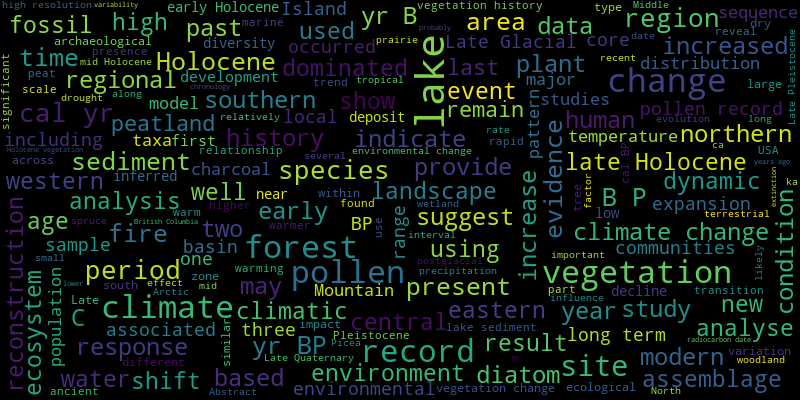

In [29]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

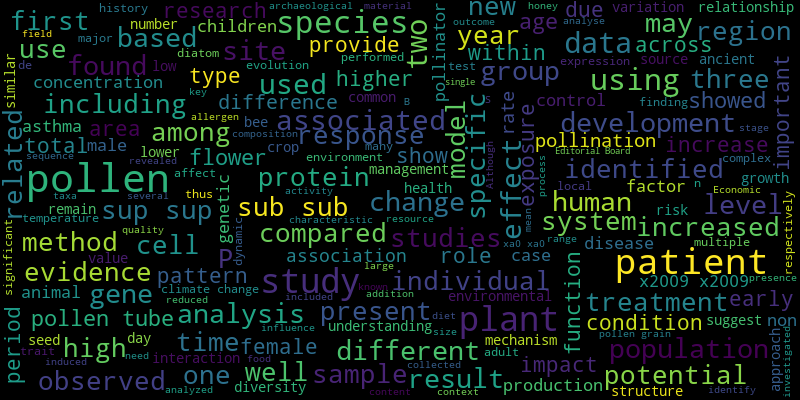

In [30]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [31]:
train_df["target"].value_counts(normalize=True)

0    0.79566
1    0.20434
Name: target, dtype: float64

## 3.3 Define Preprocessor

In [32]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target'],
      dtype='object')

In [33]:
X_train, y_train = train_df.drop(columns = ["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns = ["target"]), test_df["target"]

In [35]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

subject_feature = 'subject_clean'
subject_transformer = CountVectorizer(stop_words="english", max_features= 1000)

text_feature = "text_with_abstract"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprossor", binary_transformer, binary_feature),
    ("subject_preprocessor", text_transformer, subject_feature),
    ("text_preprocessor", text_transformer, text_feature)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprossor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('subject_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean'),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'text_with_abstract')])

##### Check Transformed Data

In [43]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

<3548x1325 sparse matrix of type '<class 'numpy.float64'>'
	with 111462 stored elements in Compressed Sparse Row format>

In [41]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["binary_preprossor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist()
             )
len(col_names)

1325

In [48]:
# Number of features from descriptive text 
len(preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist())

1000

In [49]:
# Number of features from subject
len(preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist())

323

In [50]:
transformed_X_train_df = pd.DataFrame.sparse.from_spmatrix(transformed_X_train, columns=col_names)
transformed_X_train_df.head()

,is-referenced-by-count,has_abstract_1,accounting,administration,advanced,aerospace,aging,agricultural,agronomy,aided,...,x442,xa0,xb1,xe9,year,years,yield,younger,yr,zone
0,-0.335283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.386422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.022687,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.284144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.124964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.4 Baseline Models Comparison

In [1]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [58]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [59]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [103]:
results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(class_weight="balanced", random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(class_weight="balanced", random_state=123),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=123),
    'XGBoost': XGBClassifier(class_weight="balanced", random_state=123, verbosity=0),
    # 'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
    # 'sklearn_GB': GradientBoostingClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, 
                                                  scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.245 (+/- 0.008),0.058 (+/- 0.003),0.796 (+/- 0.000),0.796 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.297 (+/- 0.043),0.055 (+/- 0.001),0.948 (+/- 0.006),0.997 (+/- 0.000),0.859 (+/- 0.019),0.988 (+/- 0.003),0.895 (+/- 0.019),0.996 (+/- 0.002),0.876 (+/- 0.014),0.992 (+/- 0.001)
Decision Tree,0.346 (+/- 0.061),0.058 (+/- 0.004),0.911 (+/- 0.009),1.000 (+/- 0.000),0.762 (+/- 0.021),1.000 (+/- 0.000),0.821 (+/- 0.033),1.000 (+/- 0.000),0.790 (+/- 0.023),1.000 (+/- 0.000)
kNN,0.277 (+/- 0.023),0.596 (+/- 0.039),0.893 (+/- 0.012),0.930 (+/- 0.003),0.722 (+/- 0.025),0.814 (+/- 0.013),0.778 (+/- 0.046),0.851 (+/- 0.011),0.749 (+/- 0.032),0.832 (+/- 0.008)
Naive Bayes,0.253 (+/- 0.023),0.057 (+/- 0.003),0.934 (+/- 0.008),0.941 (+/- 0.002),0.794 (+/- 0.024),0.809 (+/- 0.007),0.917 (+/- 0.023),0.933 (+/- 0.004),0.851 (+/- 0.016),0.867 (+/- 0.004)
RBF SVM,0.926 (+/- 0.068),0.236 (+/- 0.015),0.944 (+/- 0.007),0.979 (+/- 0.002),0.872 (+/- 0.034),0.935 (+/- 0.010),0.850 (+/- 0.006),0.967 (+/- 0.005),0.861 (+/- 0.014),0.951 (+/- 0.005)
RF,0.866 (+/- 0.030),0.074 (+/- 0.004),0.962 (+/- 0.008),1.000 (+/- 0.000),0.950 (+/- 0.021),1.000 (+/- 0.000),0.859 (+/- 0.024),1.000 (+/- 0.000),0.902 (+/- 0.022),1.000 (+/- 0.000)
LGBM,0.461 (+/- 0.017),0.077 (+/- 0.004),0.957 (+/- 0.005),1.000 (+/- 0.000),0.905 (+/- 0.030),1.000 (+/- 0.000),0.886 (+/- 0.022),1.000 (+/- 0.000),0.895 (+/- 0.012),1.000 (+/- 0.000)
CatBoost,4.931 (+/- 0.086),0.070 (+/- 0.004),0.952 (+/- 0.009),0.992 (+/- 0.001),0.941 (+/- 0.019),0.999 (+/- 0.001),0.814 (+/- 0.035),0.963 (+/- 0.004),0.873 (+/- 0.024),0.981 (+/- 0.002)
XGBoost,0.569 (+/- 0.035),0.083 (+/- 0.003),0.953 (+/- 0.007),0.999 (+/- 0.000),0.917 (+/- 0.022),1.000 (+/- 0.000),0.848 (+/- 0.038),0.994 (+/- 0.002),0.881 (+/- 0.019),0.997 (+/- 0.001)


##### Summary
- Test Recall: Naive Bayes > LGBM > Logistic regression > RF
- Test Precision: RF > SVM > LGBM > Logistic regression
- Test f1: RF ~ LGBM > Logistic regression > Naive Bayes > SVM
- Model overfit: there are signs of overfit, require hyperparameter tuning and feature selection

Since Gradient Boosted trees seem to perform well on our dataset, XGboost, catboost, sklearn's hist gradient boost and gradient boost are added to the list as an experiment. 

LGBM remains to be the best performing model of all gradient boosted model.

Naive Bayes' low precision will result in too many false positives so we do not go with this model.

In the next few steps, we will focus on logistic regression and LGBM. 


## 4. Feature Selection

### 4.1 Feature Selection on Various Models
Based on the initial results, we will apply feature selection to selected models.

Use logisitic regression for classification, L1 regularization to enable feature selection. Pass the feature with non-zero coefficient to the model. 


In [104]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000, random_state= 123)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

In [70]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.254 (+/- 0.019),0.060 (+/- 0.007),0.796 (+/- 0.000),0.796 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.293 (+/- 0.009),0.058 (+/- 0.003),0.951 (+/- 0.006),0.995 (+/- 0.000),0.893 (+/- 0.017),0.999 (+/- 0.001),0.863 (+/- 0.023),0.977 (+/- 0.003),0.878 (+/- 0.016),0.988 (+/- 0.001)
Decision Tree,0.315 (+/- 0.006),0.056 (+/- 0.002),0.919 (+/- 0.011),1.000 (+/- 0.000),0.787 (+/- 0.028),1.000 (+/- 0.000),0.832 (+/- 0.028),1.000 (+/- 0.000),0.808 (+/- 0.024),1.000 (+/- 0.000)
kNN,0.274 (+/- 0.021),0.604 (+/- 0.027),0.893 (+/- 0.012),0.930 (+/- 0.003),0.722 (+/- 0.025),0.814 (+/- 0.013),0.778 (+/- 0.046),0.851 (+/- 0.011),0.749 (+/- 0.032),0.832 (+/- 0.008)
Naive Bayes,0.241 (+/- 0.021),0.055 (+/- 0.002),0.934 (+/- 0.008),0.941 (+/- 0.002),0.794 (+/- 0.024),0.809 (+/- 0.007),0.917 (+/- 0.023),0.933 (+/- 0.004),0.851 (+/- 0.016),0.867 (+/- 0.004)
RBF SVM,0.833 (+/- 0.064),0.212 (+/- 0.017),0.942 (+/- 0.006),0.972 (+/- 0.003),0.949 (+/- 0.014),0.988 (+/- 0.005),0.759 (+/- 0.037),0.873 (+/- 0.014),0.843 (+/- 0.020),0.927 (+/- 0.008)
RF,0.840 (+/- 0.038),0.072 (+/- 0.004),0.962 (+/- 0.008),1.000 (+/- 0.000),0.950 (+/- 0.021),1.000 (+/- 0.000),0.859 (+/- 0.024),1.000 (+/- 0.000),0.902 (+/- 0.022),1.000 (+/- 0.000)
LGBM,0.483 (+/- 0.035),0.078 (+/- 0.006),0.961 (+/- 0.003),1.000 (+/- 0.000),0.933 (+/- 0.017),1.000 (+/- 0.000),0.872 (+/- 0.019),0.998 (+/- 0.001),0.901 (+/- 0.008),0.999 (+/- 0.001)
CatBoost,4.885 (+/- 0.092),0.069 (+/- 0.002),0.952 (+/- 0.009),0.992 (+/- 0.001),0.941 (+/- 0.019),0.999 (+/- 0.001),0.814 (+/- 0.035),0.963 (+/- 0.004),0.873 (+/- 0.024),0.981 (+/- 0.002)
XGBoost,0.590 (+/- 0.039),0.085 (+/- 0.006),0.953 (+/- 0.007),0.999 (+/- 0.000),0.917 (+/- 0.022),1.000 (+/- 0.000),0.848 (+/- 0.038),0.994 (+/- 0.002),0.881 (+/- 0.019),0.997 (+/- 0.001)


### 4.2 Investigate Selected Features

- Originally, transformed X_train has 1325 input features. 
- Logistic regression with L1 regularization results reduce the input dimension to 355.

> Model Performance comparison:

- Feature Selection + Logistic Regression

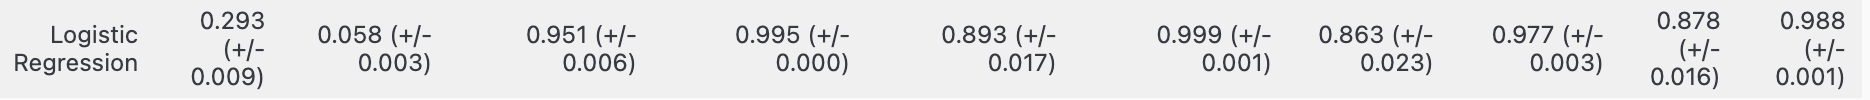

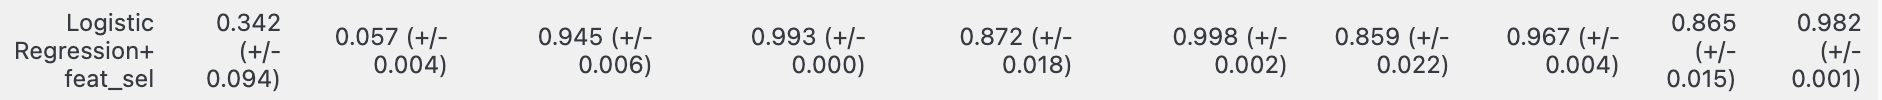

- Feature Selection + LGBM

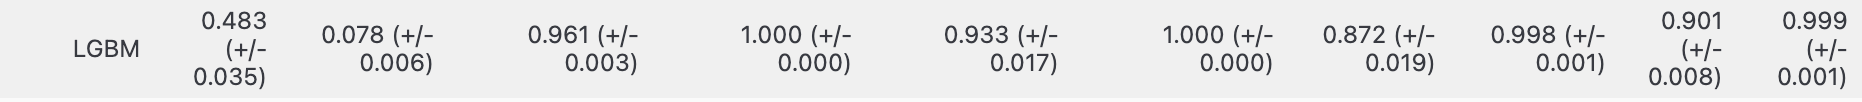

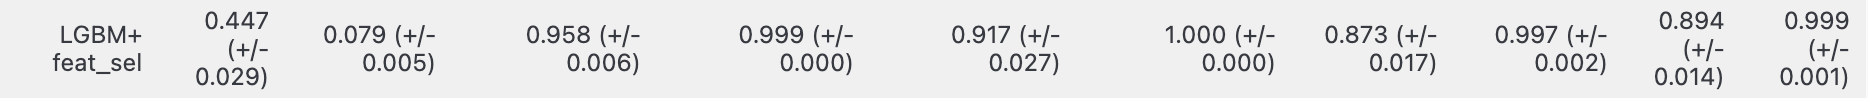

In [74]:
pipe_fs = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_fs.fit(X_train, y_train)

print(
    "Number of features selected: ",
    pipe_fs.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  355


## 5. Model Evaluation

### 5.1 Logistic Regression without feature selection

- Decide to set the baseline model without feature selection to achieve higher recall and f1 scores

In [92]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprossor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('subject_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean'),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'text_with_abstract')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

#### 5.1.1 Classification Reports

In [94]:
logreg_model.classes_ # make sure which class is positive

array([0, 1])

In [95]:
from sklearn.metrics import classification_report
y_pred = logreg_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.96      0.99      0.97       700
    relevant       0.94      0.85      0.89       187

    accuracy                           0.96       887
   macro avg       0.95      0.92      0.93       887
weighted avg       0.96      0.96      0.96       887



#### PR Curve

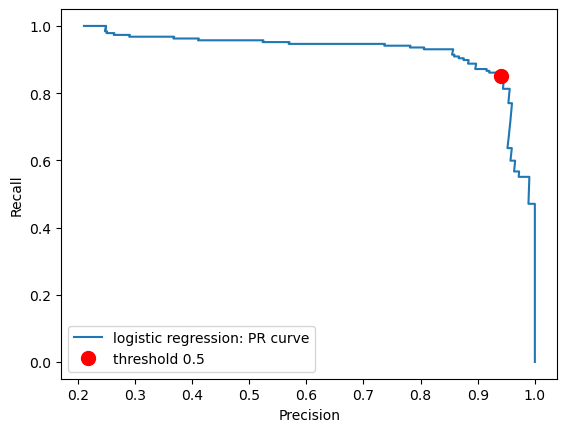

In [88]:
thresholds = np.arange(0.0, 1.0, 0.1)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg_model.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, logreg_model.predict(X_test)),
    recall_score(y_test, logreg_model.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best")

#### ROC Curve

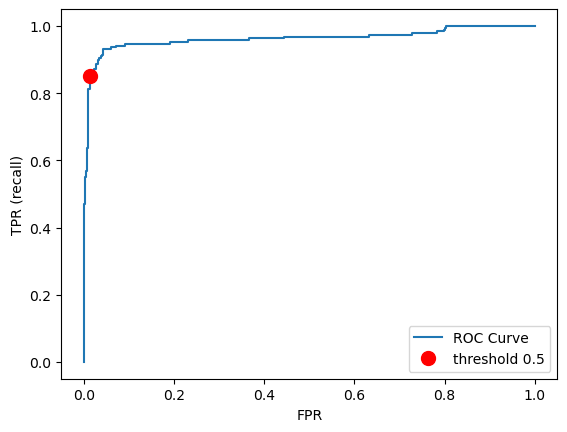

In [90]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

#### 5.1.2 Feature importance for Logistic Regression

In [77]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [78]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
paleontology,2.082382,2.082382
plant,1.738613,1.738613
lake,1.719093,1.719093
has_abstract_1,1.706695,1.706695
archeology,1.659378,1.659378
earth,1.502964,1.502964
holocene,1.478647,1.478647
aquatic,1.425015,1.425015
geology,1.334934,1.334934
radiocarbon,1.270543,1.270543


In [80]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
sustainability,-1.672184,1.672184
editorial,-1.568480,1.568480
mathematics,-1.204529,1.204529
econometrics,-1.204331,1.204331
economics,-1.204331,1.204331
space,-1.131285,1.131285
issue,-1.071847,1.071847
influenza,-1.046534,1.046534
review,-0.951268,0.951268
cover,-0.947495,0.947495


#### 5.1.3 Recall by group  (has abstract or not to see if the model is biased toward a certain group)

In [96]:
from sklearn.metrics import recall_score

# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

In [97]:
# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group 
print(grouped_recall)

has_abstract
0    1.000000
1    0.955774
dtype: float64


Calculate precision for each group

In [98]:
from sklearn.metrics import precision_score

grouped_precision = grouped_data.apply(lambda x: precision_score(x['target'], x['predictions']))
print(grouped_precision)

has_abstract
0    1.0
1    1.0
dtype: float64


### 5.2 LGBM without feature selection

In [105]:
lgbm_model = make_pipeline(preprocessor, LGBMClassifier(max_iter=1000, random_state=123))
lgbm_model.fit(X_train, y_train)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprossor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('subject_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean'),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'text_with_abstract')])),
                ('lgbmclassifier',
                 LGBMClassifier(max_iter=1000, random_state=123))])

In [106]:
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))

              precision    recall  f1-score   support

non-relevant       0.96      0.98      0.97       700
    relevant       0.92      0.83      0.88       187

    accuracy                           0.95       887
   macro avg       0.94      0.91      0.92       887
weighted avg       0.95      0.95      0.95       887



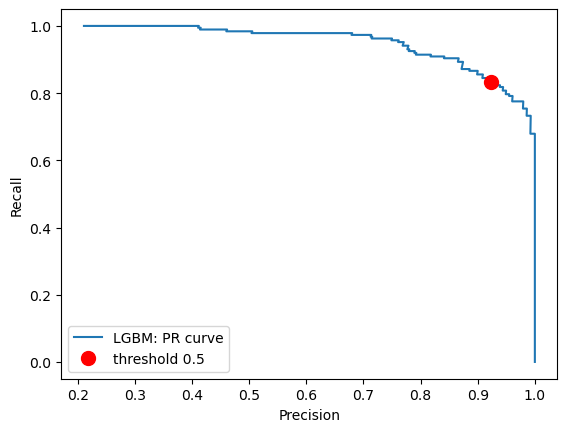

In [108]:
thresholds = np.arange(0.0, 1.0, 0.1)
precision, recall, thresholds = precision_recall_curve(
    y_test, lgbm_model.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="LGBM: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, lgbm_model.predict(X_test)),
    recall_score(y_test, lgbm_model.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best")

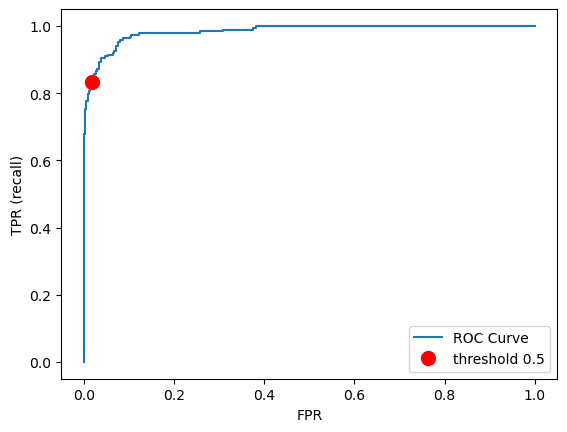

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

#### 5.2.2 Feature importance for LGBM

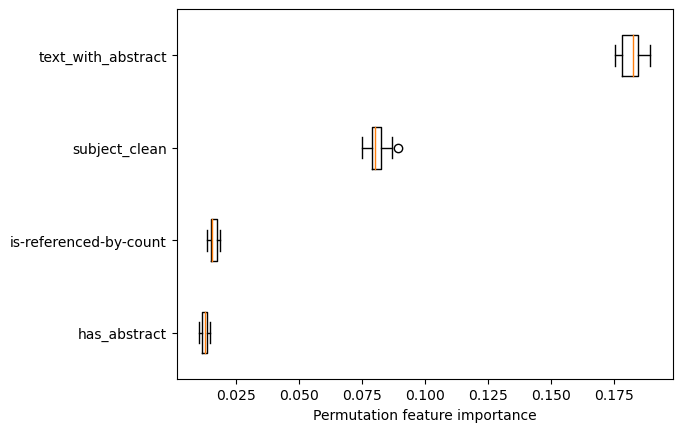

In [111]:
from sklearn.inspection import permutation_importance

def get_permutation_importance(model):
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=123)
    perm_sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_train.columns[perm_sorted_idx],
    )
    plt.xlabel('Permutation feature importance')
    plt.show()
    
get_permutation_importance(lgbm_model)

#### 5.3 Model Mistakes

In [118]:
test_df['lr_pred'] = logreg_model.predict(X_test)
test_df['lgbm_pred'] = lgbm_model.predict(X_test)
test_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
3699,4,0,Immunology Immunology and Allergy,Understanding racial disparities in childhood asthma using individual- and neighborhood-level risk factors Racial disparities in childhood asthma outcomes result from a complex interplay of indiv...,0,0,0
4415,0,0,"Public Health, Environmental and Occupational Health Genetics Aging Physiology Epidemiology","Leopoli-Cencelle (9th–15th centuries CE), a centre of Papal foundation: bioarchaeological analysis of the skeletal remains of its inhabitants The medieval city of Leopoli-Cencelle (9th-15th centu...",0,0,0
4062,0,0,Immunology Immunology and Allergy,Immunoglobulin repertoire restriction characterizes the serological responses of patients with predominantly antibody deficiency Predominantly antibody deficiency (PAD) is the most common categor...,0,0,0
1226,6,1,Animal Science and Zoology Food Animals,A continuous recording approach to qualitative behaviour assessment in dairy buffaloes (Bubalus bubalis),0,0,0
15,103,1,Multidisciplinary,Radiocarbon evidence of mid-Holocene mammoths stranded on an Alaskan Bering Sea island,1,1,1


### 5.3.1 Logistic Regression FP & FN

In [121]:
# False Positives on Test Set
FP_LR = test_df.query('target == 0 & lr_pred == 1')
print(f'There are {FP_LR.shape[0]} False Positive in test set using Logistic regression')
FP_LR

There are 10 False Positive in test set using Logistic regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
987,19,1,General Earth and Planetary Sciences General Social Sciences,Predicting support for non-pharmaceutical interventions during infectious outbreaks: a four region analysis,0,1,1
3952,2,0,"Plant Science Ecology Ecology, Evolution, Behavior and Systematics","Taxon Cycles in Neotropical Mangroves The concept of the taxon cycle involves successive range expansions and contractions over time, through which a species can indefinitely maintain its core di...",0,1,0
3125,52,0,Multidisciplinary,"Humans thrived in South Africa through the Toba eruption about 74,000 years ago Approximately 74 thousand years ago (ka), the Toba caldera erupted in Sumatra. Since the magnitude of this eruption...",0,1,0
3972,25,0,Multidisciplinary,"Miniaturization optimized weapon killing power during the social stress of late pre-contact North America (AD 600-1600) Before Europeans arrived to Eastern North America, prehistoric, indigenous ...",0,1,0
2182,6,1,General Earth and Planetary Sciences,A Space-Time Raster GIS Data Model for Spatiotemporal Analysis of Vegetation Responses to a Freeze Event Spatiotemporal Analysis of Vegetation Responses to a Freeze Event,0,1,0
3168,36,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Stable isotope paleoecology of Late Pleistocene Middle Stone Age humans from the Lake Victoria basin, Kenya Paleoanthropologists have long argued that environmental pressures played a key role in...",0,1,0
4001,5,0,General Earth and Planetary Sciences,Medium-Term Increases in Ambient Grass Pollen Between 1994-1999 and 2016-2020 in a Subtropical Climate Zone Grass pollen is the major outdoor trigger of allergic respiratory diseases. Climate cha...,0,1,1
2779,6,1,Multidisciplinary,Radiocarbon dating the end of urban services in a late Roman town,0,1,1
3991,5,0,Pollution Waste Management and Disposal Environmental Chemistry Environmental Engineering,"Modelling and prediction of wind damage in forest ecosystems of the Sudety Mountains, SW Poland Windstorms are one of the most important disturbance factors in European forest ecosystems. An unde...",0,1,0
2627,1,0,Multidisciplinary,"Settlement, environment, and climate change in SW Anatolia: Dynamics of regional variation and the end of Antiquity ""This paper develops a regional dataset of change at 381 settlements for Lycia-...",0,1,0


In [123]:
# False Negatives on Test Set
FN_LR = test_df.query('target == 1 & lr_pred == 0')
print(f'There are {FN_LR.shape[0]} False Negative in test set using Logistic regression')
FN_LR

There are 28 False Negative in test set using Logistic regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
31,53,0,General Arts and Humanities Archeology,"Prehistoric human impacts on Rapa, French Polynesia New excavations and survey on the island of Rapa have shown that a rockshelter was occupied by early settlers around AD 1200 and the first hil...",1,0,1
77,0,1,,Summary report of the operations of the Geological Survey for the calendar year 1902,1,0,0
554,11,1,Geochemistry and Petrology Geophysics,"Eruption and mass-wasting-induced processes during the late holocene destructive phase of Nevado del Ruiz volcano, Colombia",1,0,1
3672,5,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Site occupation dynamics of early modern humans at Misliya Cave (Mount Carmel, Israel): Evidence from the spatial taphonomy of faunal remains Space use in Middle Paleolithic (MP) camps has been s...",1,0,0
601,2,0,Museology Archeology Arts and Humanities (miscellaneous) History,"Bison Jump Location is Primarily Predicted by Minimizing Visibility at the Wold Site, Johnson County, Wyoming The Wold Bison Jump (48JO966) is a communal bison (Bison bison) hunting site in John...",1,0,0
188,41,1,Water Science and Technology Aquatic Science,Effects of Small Ponds on Stream Water Chemistry,1,0,1
528,13,1,Paleontology,A review of the dodo and its ecosystem: insights from a vertebrate concentration Lagerstätte in Mauritius,1,0,0
3479,0,0,Plant Science,Reclamation in southern China: The early Chu’s agriculture revealed by macro-plant remains from the Wanfunao site (ca. 1000–770 BCE) The Wanfunao site was a large Chu settlement in Zhou Dynasty. ...,1,0,0
3154,2,0,Pollution Waste Management and Disposal Environmental Chemistry Environmental Engineering,Alkalinity and diatom assemblages in lowland streams: How to separate alkalinity from inorganic phosphorus in ecological assessments? Benthic algae are widely used as ecological indicators of the...,1,0,0
3445,33,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Site fragmentation, hominin mobility and LCT variability reflected in the early Acheulean record of the Okote Member, at Koobi Fora, Kenya From its initial appearance at &#x223c;1.7&#xa0;Ma, the ...",1,0,0


### 5.3.2 LGBM FP & FN

In [124]:
# False Positives on Test Set
FP_LGBM = test_df.query('target == 0 & lgbm_pred == 1')
print(f'There are {FP_LGBM.shape[0]} False Positive in test set using LGBM regression')
FP_LGBM

There are 13 False Positive in test set using LGBM regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
987,19,1,General Earth and Planetary Sciences General Social Sciences,Predicting support for non-pharmaceutical interventions during infectious outbreaks: a four region analysis,0,1,1
2686,12,1,Multidisciplinary,"Evidence grows that peopling of the Americas began more than 20,000 years ago",0,0,1
3928,1,0,Multidisciplinary,"The largest amber-preserved flower revisited Amber exquisitely preserves the delicate organs of fossil flowers for millions of years. However, flower inclusions can be rare and usually do not exc...",0,0,1
4089,5,0,Archeology Anthropology Archeology,"Let’s groove: attachment techniques of Eurasian elk (Alces alces) tooth pendants at the Late Mesolithic cemetery Yuzhniy Oleniy Ostrov (Lake Onega, Russia) More than 4300 Eurasian elk (<i>Alces a...",0,0,1
3566,10,0,"Library and Information Sciences Statistics, Probability and Uncertainty Computer Science Applications Education Information Systems Statistics and Probability","A statistics-based reconstruction of high-resolution global terrestrial climate for the last 800,000 years Curated global climate data have been generated from climate model outputs for the last ...",0,0,1
4001,5,0,General Earth and Planetary Sciences,Medium-Term Increases in Ambient Grass Pollen Between 1994-1999 and 2016-2020 in a Subtropical Climate Zone Grass pollen is the major outdoor trigger of allergic respiratory diseases. Climate cha...,0,1,1
2779,6,1,Multidisciplinary,Radiocarbon dating the end of urban services in a late Roman town,0,1,1
2577,23,0,"Anthropology Ecology, Evolution, Behavior and Systematics",Relevance of the eastern African coastal forest for early hominin biogeography The influence of climate change on hominin evolution is much debated. Two issues hamper our understanding of this pr...,0,0,1
3057,10,0,General Environmental Science Ecology Environmental Chemistry Global and Planetary Change,Rising temperature modulates pH niches of fen species Rising temperatures may endanger fragile ecosystems because their character and key species show different habitat affinities under different...,0,0,1
2813,7,0,Multidisciplinary,"The anurans and squamates assemblage from Final Natufian Eynan (Ain Mallaha, Israel) with an emphasis on snake-human interactions ""During the Natufian period, more than 12,000 years ago, Eynan (A...",0,0,1


In [125]:
# False Positives on Test Set
FN_LGBM = test_df.query('target == 1 & lgbm_pred == 0')
print(f'There are {FN_LGBM.shape[0]} False Negative in test set using LGBM regression')
FN_LGBM

There are 31 False Negative in test set using LGBM regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
77,0,1,,Summary report of the operations of the Geological Survey for the calendar year 1902,1,0,0
4146,39,0,Multidisciplinary,"Native American fire management at an ancient wildland–urban interface in the Southwest United States ""The intersection of expanding human development and wildland landscapes-the """"wildland-urban...",1,1,0
3672,5,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Site occupation dynamics of early modern humans at Misliya Cave (Mount Carmel, Israel): Evidence from the spatial taphonomy of faunal remains Space use in Middle Paleolithic (MP) camps has been s...",1,0,0
601,2,0,Museology Archeology Arts and Humanities (miscellaneous) History,"Bison Jump Location is Primarily Predicted by Minimizing Visibility at the Wold Site, Johnson County, Wyoming The Wold Bison Jump (48JO966) is a communal bison (Bison bison) hunting site in John...",1,0,0
528,13,1,Paleontology,A review of the dodo and its ecosystem: insights from a vertebrate concentration Lagerstätte in Mauritius,1,0,0
3479,0,0,Plant Science,Reclamation in southern China: The early Chu’s agriculture revealed by macro-plant remains from the Wanfunao site (ca. 1000–770 BCE) The Wanfunao site was a large Chu settlement in Zhou Dynasty. ...,1,0,0
3154,2,0,Pollution Waste Management and Disposal Environmental Chemistry Environmental Engineering,Alkalinity and diatom assemblages in lowland streams: How to separate alkalinity from inorganic phosphorus in ecological assessments? Benthic algae are widely used as ecological indicators of the...,1,0,0
627,78,0,Multidisciplinary,"Carbon starvation in glacial trees recovered from the La Brea tar pits, southern California \n The Rancho La Brea tar pit fossil collection includes\n Juniperus \n ...",1,1,0
3445,33,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Site fragmentation, hominin mobility and LCT variability reflected in the early Acheulean record of the Okote Member, at Koobi Fora, Kenya From its initial appearance at &#x223c;1.7&#xa0;Ma, the ...",1,0,0
632,32,1,Pollution Water Science and Technology Ecological Modeling Environmental Chemistry Environmental Engineering,Algal microfossils provide high temporal resolution of environmental trends,1,0,0


# 6. Summary for Baseline Models

Benchmarks
- Logistic Regression with BOW text features
    - Precision 0.94
    - Recall 0.85
    - F1 0.89

- LGBM with BOW text features
    - Precision 0.92
    - Recall 0.83
    - F1 0.88

Notes:
- Adding has_abstract could help non-linear model to learn the non-linearity for articles with/without abstract. However for linear models, it might become a relatively important feature and bias toward articles with abstract.

- Threshold 0.5 could possibly be adjusted to optimize recall more (while keeping precison at a reasonably high level)